<a href="https://colab.research.google.com/github/Jaristilde/NLP_Algo_Harness_part2.ipynb/blob/main/Jonae_NLP_Algo_Harness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Get the Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


# Step 1: Install and Import the Libs

In [ ]:
import nltk
nltk.download('punkt_tab')
# Install additional libraries
!pip install xgboost lightgbm catboost -qqq

# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 2: Load the Dataset

In [ ]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Step 3: Data Cleaning and Preprocessing

## 3.1 Identify Feature and Target Columns

In [ ]:
# your dataset may have 100 columns... which of those columns has the text that you want to train?  and which column represents what you want to predict?

In [ ]:
# Rename columns for consistency
df = df.rename(columns={'review': 'text', 'sentiment': 'target'})

# The target column is categorical, so we will convert it to a numerical format (0 and 1)
df['target'] = df['target'].apply(lambda x: 1 if x == 'positive' else 0)  # Clearly you will have to rename this for your dataset

print(df.head())

                                                text  target
0  One of the other reviewers has mentioned that ...       1
1  A wonderful little production. <br /><br />The...       1
2  I thought this was a wonderful way to spend ti...       1
3  Basically there's a family where a little boy ...       0
4  Petter Mattei's "Love in the Time of Money" is...       1


## 3.2 Text Cleaning

In [ ]:
# Be careful about running this cell twice!

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Apply the cleaning function to the text column
df['text'] = df['text'].apply(clean_text)

print(df.head())

                                                text  target
0  one of the other reviewers has mentioned that ...       1
1  a wonderful little production the filming tech...       1
2  i thought this was a wonderful way to spend ti...       1
3  basically theres a family where a little boy j...       0
4  petter matteis love in the time of money is a ...       1


## 3.3 Tokenization

In [ ]:
# Tokenize the text  (it is up to you how you tokenize... but i am starting with word tokenization )
df['text'] = df['text'].apply(nltk.word_tokenize)

print(df.head())

                                                text  target
0  [one, of, the, other, reviewers, has, mentione...       1
1  [a, wonderful, little, production, the, filmin...       1
2  [i, thought, this, was, a, wonderful, way, to,...       1
3  [basically, theres, a, family, where, a, littl...       0
4  [petter, matteis, love, in, the, time, of, mon...       1


## 3.4 Stop Word Removal

In [ ]:
# Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

print(df.head())

                                                text  target
0  [one, reviewers, mentioned, watching, oz, epis...       1
1  [wonderful, little, production, filming, techn...       1
2  [thought, wonderful, way, spend, time, hot, su...       1
3  [basically, theres, family, little, boy, jake,...       0
4  [petter, matteis, love, time, money, visually,...       1


## 3.5: Stemming and Lemmatization

In [ ]:
# Lemmatize the text
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Join the tokens back into a single string
df['text'] = df['text'].apply(lambda x: ' '.join(x))

print(df.head())

                                                text  target
0  one reviewer mentioned watching oz episode you...       1
1  wonderful little production filming technique ...       1
2  thought wonderful way spend time hot summer we...       1
3  basically there family little boy jake think t...       0
4  petter matteis love time money visually stunni...       1


# 4 Feature Engineering (Text Representation)

In [ ]:
# Separate features (X) and target (y)
X = df['text']
y = df['target']

# Split the data into training and testing sets  --- this is super important...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # We will use the top 5000 most frequent words  ***this is a hidden hyperparameter

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3113201 stored elements and shape (40000, 5000)>

# 5. Build and Evaluate the Algorithm Harness

## 5.1 Define a list of Classifier (AI Models)

In [ ]:
# Define a list of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    # "SVC": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [ ]:
# # Comprehensive list of classifiers
# classifiers = {
#     # Linear Models
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
#     "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
#     "Logistic Regression (Balanced)": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
#     "Ridge Classifier": RidgeClassifier(random_state=42),
#     "SGD Classifier": SGDClassifier(max_iter=1000, random_state=42),
#     "SGD Classifier (log loss)": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
#     "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=42),

#     # Naive Bayes
#     "Multinomial NB": MultinomialNB(),
#     "Multinomial NB (alpha=0.5)": MultinomialNB(alpha=0.5),
#     "Bernoulli NB": BernoulliNB(),
#     "Complement NB": ComplementNB(),

#     # SVM
#     "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
#     "Linear SVC (Balanced)": LinearSVC(max_iter=1000, class_weight='balanced', random_state=42),

#     # Tree-based Models
#     "Decision Tree": DecisionTreeClassifier(random_state=42),
#     "Decision Tree (max_depth=10)": DecisionTreeClassifier(max_depth=10, random_state=42),
#     "Decision Tree (Balanced)": DecisionTreeClassifier(class_weight='balanced', random_state=42),

#     # Random Forests
#     "Random Forest": RandomForestClassifier(random_state=42),
#     "Random Forest (100 trees)": RandomForestClassifier(n_estimators=100, random_state=42),
#     "Random Forest (200 trees)": RandomForestClassifier(n_estimators=200, random_state=42),
#     "Random Forest (Balanced)": RandomForestClassifier(class_weight='balanced', random_state=42),
#     "Random Forest (max_depth=10)": RandomForestClassifier(max_depth=10, random_state=42),

#     # Extra Trees
#     "Extra Trees": ExtraTreesClassifier(random_state=42),
#     "Extra Trees (100 trees)": ExtraTreesClassifier(n_estimators=100, random_state=42),

#     # Gradient Boosting
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#     "Gradient Boosting (learning_rate=0.05)": GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, random_state=42),
#     "Gradient Boosting (max_depth=5)": GradientBoostingClassifier(max_depth=5, random_state=42),

#     # AdaBoost
#     "AdaBoost": AdaBoostClassifier(random_state=42),
#     "AdaBoost (100 estimators)": AdaBoostClassifier(n_estimators=100, random_state=42),
#     "AdaBoost (learning_rate=0.5)": AdaBoostClassifier(learning_rate=0.5, random_state=42),

#     # XGBoost
#     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "XGBoost (max_depth=5)": xgb.XGBClassifier(max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "XGBoost (learning_rate=0.05)": xgb.XGBClassifier(learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "XGBoost (n_estimators=200)": xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42),

#     # LightGBM
#     "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
#     "LightGBM (num_leaves=50)": lgb.LGBMClassifier(num_leaves=50, random_state=42, verbose=-1),
#     "LightGBM (learning_rate=0.05)": lgb.LGBMClassifier(learning_rate=0.05, random_state=42, verbose=-1),
#     "LightGBM (n_estimators=200)": lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),

#     # CatBoost
#     "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
#     "CatBoost (depth=5)": CatBoostClassifier(depth=5, verbose=0, random_state=42),
#     "CatBoost (learning_rate=0.05)": CatBoostClassifier(learning_rate=0.05, verbose=0, random_state=42),
#     "CatBoost (iterations=200)": CatBoostClassifier(iterations=200, verbose=0, random_state=42),

#     # Bagging
#     "Bagging (Logistic Regression)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000), random_state=42),
#     "Bagging (Decision Tree)": BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),

#     # K-Nearest Neighbors
#     "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
#     "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
#     "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),

#     # Neural Networks
#     "MLP (hidden_layer=100)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
#     "MLP (hidden_layer=100,50)": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
#     "MLP (hidden_layer=200)": MLPClassifier(hidden_layer_sizes=(200,), max_iter=1000, random_state=42),

#     # Linear Discriminant Analysis
#     "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
# }

# print(f"Total number of classifiers: {len(classifiers)}")

## 5.2 Train and Evaluate the Models in a Loop

In [ ]:
from tqdm import tqdm

# Create a list to store the results
results_list = []

# Loop through the classifiers with progress bar
for name, clf in tqdm(classifiers.items(), desc="Training models", total=len(classifiers)):
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")

    # Train the classifier
    clf.fit(X_train_tfidf, y_train)
    print("✓ Training complete")

    # Make predictions on the test data
    y_pred = clf.predict(X_test_tfidf)
    print("✓ Predictions complete")

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Print results immediately
    print(f"\nResults for {name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

    # Add the results to the list
    results_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    })

# Create DataFrame from the list
results = pd.DataFrame(results_list)

# Sort the results by ROC-AUC score
results = results.sort_values(by='ROC-AUC', ascending=False)

print(f"\n{'='*60}")
print("FINAL RESULTS (sorted by ROC-AUC)")
print(f"{'='*60}\n")
print(results.to_string(index=False))

Training models:   0%|          | 0/8 [00:00<?, ?it/s]


Training: Logistic Regression


Training models:  12%|█▎        | 1/8 [00:00<00:02,  2.34it/s]

✓ Training complete
✓ Predictions complete

Results for Logistic Regression:
  Accuracy:  0.8848
  Precision: 0.8766
  Recall:    0.8978
  F1-score:  0.8871
  ROC-AUC:   0.8847

Training: Multinomial NB
✓ Training complete
✓ Predictions complete

Results for Multinomial NB:
  Accuracy:  0.8491
  Precision: 0.8473
  Recall:    0.8545
  F1-score:  0.8509
  ROC-AUC:   0.8491

Training: Random Forest
✓ Training complete


Training models:  38%|███▊      | 3/8 [02:15<04:11, 50.32s/it]

✓ Predictions complete

Results for Random Forest:
  Accuracy:  0.8458
  Precision: 0.8553
  Recall:    0.8353
  F1-score:  0.8452
  ROC-AUC:   0.8459

Training: Gradient Boosting


Training models:  50%|█████     | 4/8 [05:00<05:59, 89.94s/it]

✓ Training complete
✓ Predictions complete

Results for Gradient Boosting:
  Accuracy:  0.8101
  Precision: 0.7815
  Recall:    0.8651
  F1-score:  0.8211
  ROC-AUC:   0.8097

Training: AdaBoost
✓ Training complete
✓ Predictions complete


Training models:  62%|██████▎   | 5/8 [05:37<03:36, 72.30s/it]


Results for AdaBoost:
  Accuracy:  0.7493
  Precision: 0.7393
  Recall:    0.7761
  F1-score:  0.7573
  ROC-AUC:   0.7491

Training: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:06:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Training models:  75%|███████▌  | 6/8 [07:03<02:33, 76.73s/it]

✓ Training complete
✓ Predictions complete

Results for XGBoost:
  Accuracy:  0.8555
  Precision: 0.8418
  Recall:    0.8783
  F1-score:  0.8597
  ROC-AUC:   0.8553

Training: LightGBM
[LightGBM] [Info] Number of positive: 19961, number of negative: 20039
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.216428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567365
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499025 -> initscore=-0.003900
[LightGBM] [Info] Start training from score -0.003900


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Training models:  88%|████████▊ | 7/8 [07:38<01:03, 63.46s/it]

✓ Training complete
✓ Predictions complete

Results for LightGBM:
  Accuracy:  0.8586
  Precision: 0.8492
  Recall:    0.8748
  F1-score:  0.8618
  ROC-AUC:   0.8585

Training: CatBoost


Training models: 100%|██████████| 8/8 [25:17<00:00, 189.71s/it]

✓ Training complete
✓ Predictions complete

Results for CatBoost:
  Accuracy:  0.8735
  Precision: 0.8601
  Recall:    0.8944
  F1-score:  0.8769
  ROC-AUC:   0.8733

FINAL RESULTS (sorted by ROC-AUC)

              Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
Logistic Regression    0.8848   0.876574 0.897797  0.887059 0.884698
           CatBoost    0.8735   0.860115 0.894423  0.876934 0.873336
           LightGBM    0.8586   0.849162 0.874777  0.861779 0.858473
            XGBoost    0.8555   0.841765 0.878349  0.859668 0.855320
     Multinomial NB    0.8491   0.847304 0.854535  0.850904 0.849057
      Random Forest    0.8458   0.855314 0.835285  0.845181 0.845883
  Gradient Boosting    0.8101   0.781463 0.865053  0.821136 0.809668
           AdaBoost    0.7493   0.739319 0.776146  0.757285 0.749089


/tmp/ipython-input-3064879488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC-AUC', y='Model', data=results, palette='viridis')


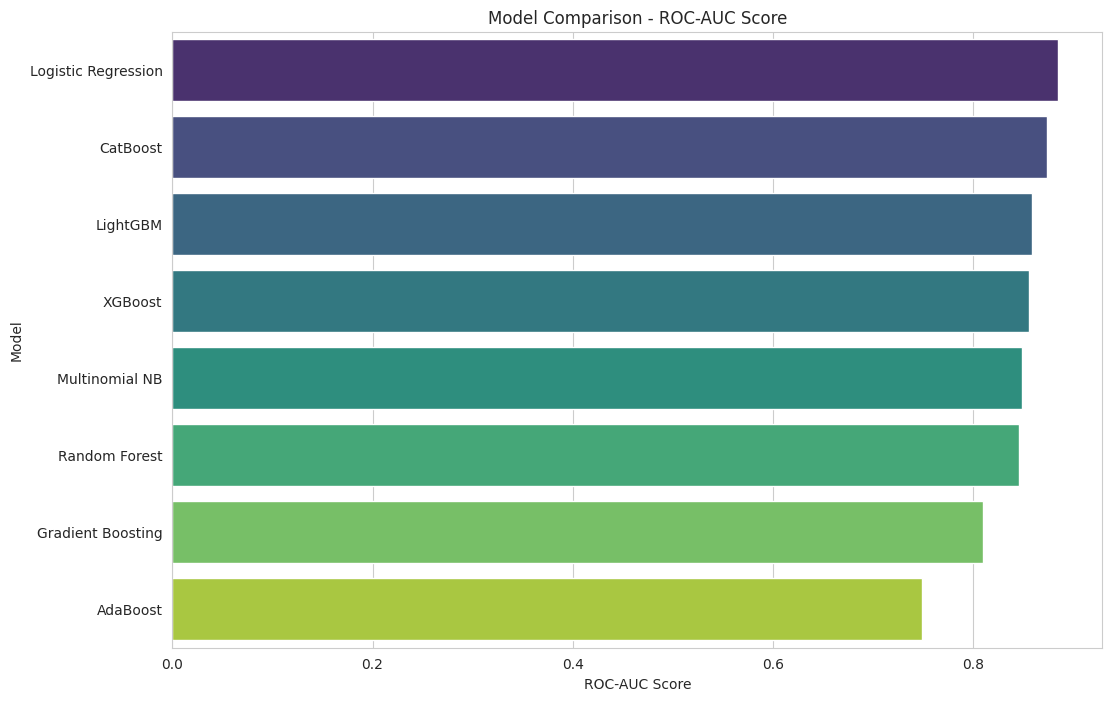

In [ ]:
# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x='ROC-AUC', y='Model', data=results, palette='viridis')
plt.title('Model Comparison - ROC-AUC Score')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Model')
plt.show()

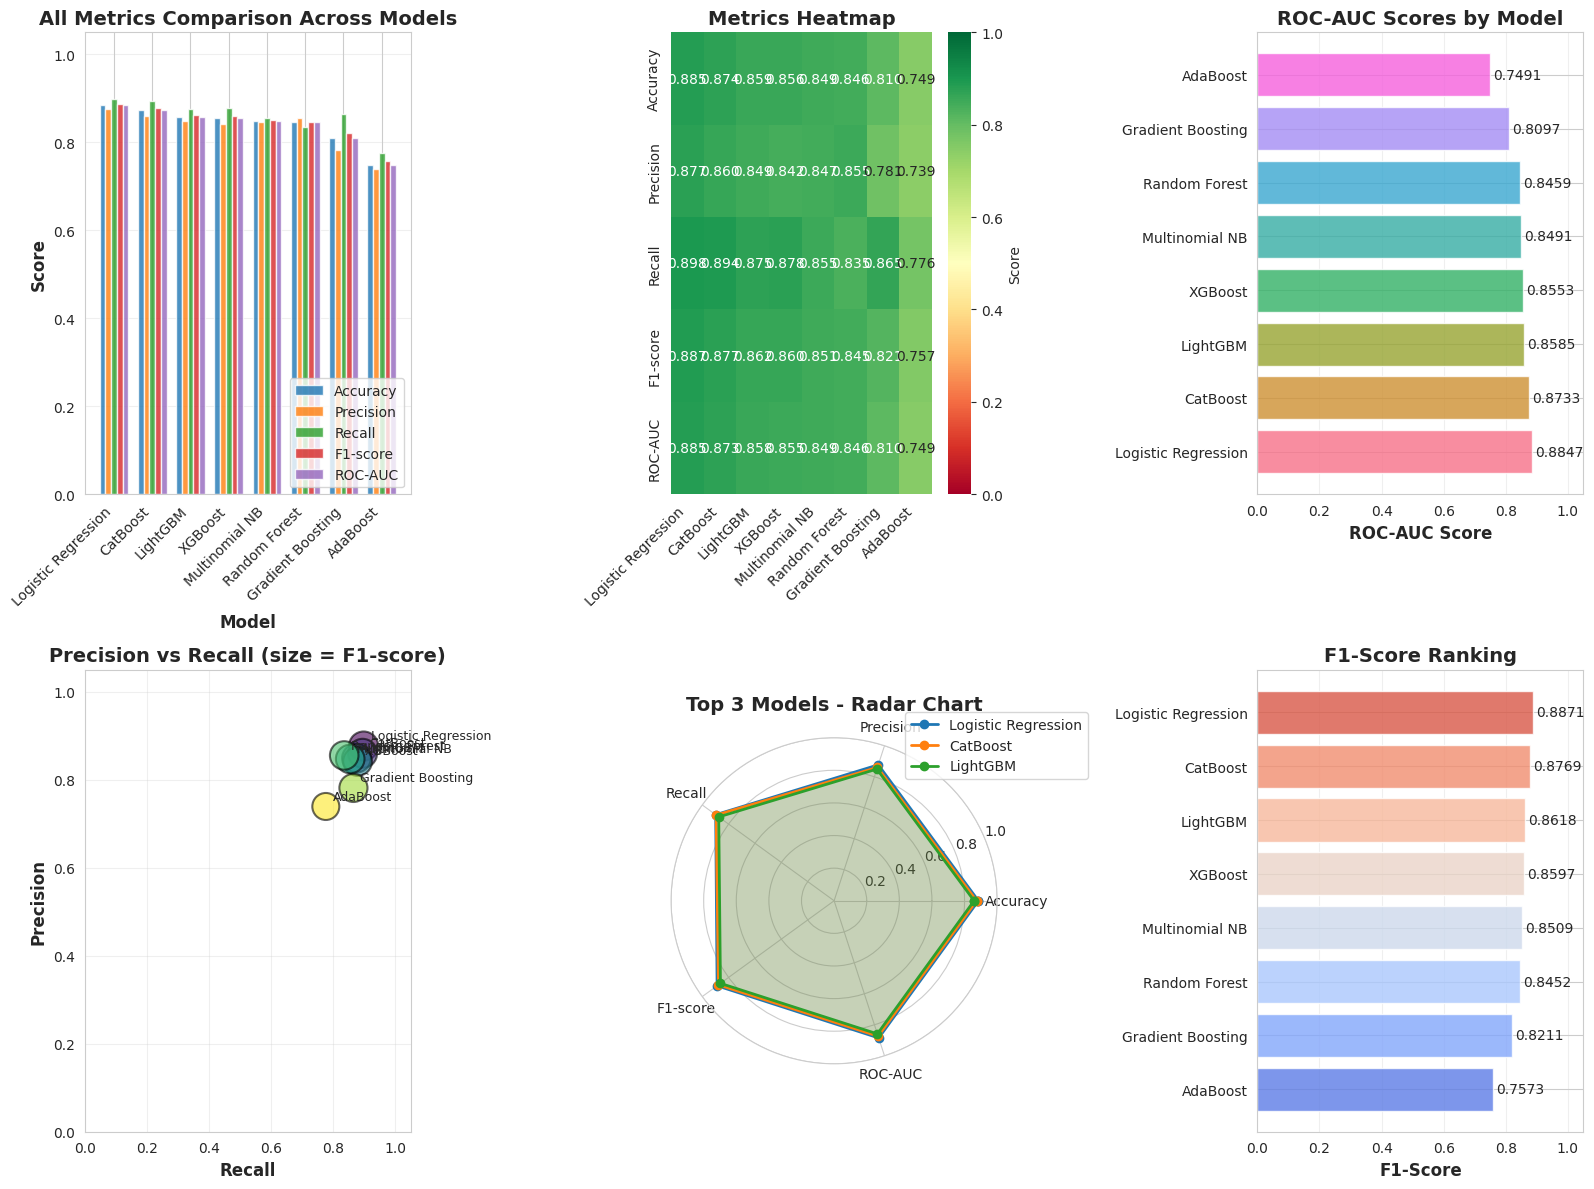


SUMMARY STATISTICS

Best performing model (by ROC-AUC): Logistic Regression
ROC-AUC Score: 0.8847

Best F1-Score: 0.8871 (Logistic Regression)
Best Precision: 0.8766 (Logistic Regression)
Best Recall: 0.8978 (Logistic Regression)
Best Accuracy: 0.8848 (Logistic Regression)

MEAN SCORES ACROSS ALL MODELS
Accuracy    : 0.8408
Precision   : 0.8314
Recall      : 0.8595
F1-score    : 0.8450
ROC-AUC     : 0.8407


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# 1. Bar chart comparing all metrics across models
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
x = np.arange(len(results))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, results[metric], width, label=metric, alpha=0.8)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('All Metrics Comparison Across Models', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(results['Model'], rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1.05])
ax1.grid(axis='y', alpha=0.3)

# 2. Heatmap of all metrics
ax2 = plt.subplot(2, 3, 2)
heatmap_data = results[metrics].T
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=results['Model'], yticklabels=metrics,
            vmin=0, vmax=1, cbar_kws={'label': 'Score'}, ax=ax2)
ax2.set_title('Metrics Heatmap', fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. ROC-AUC comparison
ax3 = plt.subplot(2, 3, 3)
colors = sns.color_palette("husl", len(results))
bars = ax3.barh(results['Model'], results['ROC-AUC'], color=colors, alpha=0.8)
ax3.set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax3.set_title('ROC-AUC Scores by Model', fontsize=14, fontweight='bold')
ax3.set_xlim([0, 1.05])
ax3.grid(axis='x', alpha=0.3)
# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, results['ROC-AUC'])):
    ax3.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=10)

# 4. Precision vs Recall scatter plot
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(results['Recall'], results['Precision'],
                     s=results['F1-score']*500, alpha=0.6, c=range(len(results)),
                     cmap='viridis', edgecolors='black', linewidth=1.5)
for i, model in enumerate(results['Model']):
    ax4.annotate(model, (results['Recall'].iloc[i], results['Precision'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax4.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax4.set_title('Precision vs Recall (size = F1-score)', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)
ax4.set_xlim([0, 1.05])
ax4.set_ylim([0, 1.05])

# 5. Radar chart for top 3 models
ax5 = plt.subplot(2, 3, 5, projection='polar')
top_3 = results.head(3)
categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for i, row in top_3.iterrows():
    values = row[metrics].values.tolist()
    values += values[:1]
    ax5.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    ax5.fill(angles, values, alpha=0.15)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, fontsize=10)
ax5.set_ylim(0, 1)
ax5.set_title('Top 3 Models - Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax5.grid(True)

# 6. F1-Score ranking
ax6 = plt.subplot(2, 3, 6)
results_sorted_f1 = results.sort_values('F1-score', ascending=True)
colors_f1 = sns.color_palette("coolwarm", len(results_sorted_f1))
bars = ax6.barh(results_sorted_f1['Model'], results_sorted_f1['F1-score'],
                color=colors_f1, alpha=0.8)
ax6.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax6.set_title('F1-Score Ranking', fontsize=14, fontweight='bold')
ax6.set_xlim([0, 1.05])
ax6.grid(axis='x', alpha=0.3)
# Add value labels
for i, (bar, value) in enumerate(zip(bars, results_sorted_f1['F1-score'])):
    ax6.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Additional: Summary statistics table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nBest performing model (by ROC-AUC): {results.iloc[0]['Model']}")
print(f"ROC-AUC Score: {results.iloc[0]['ROC-AUC']:.4f}")
print(f"\nBest F1-Score: {results['F1-score'].max():.4f} ({results.loc[results['F1-score'].idxmax(), 'Model']})")
print(f"Best Precision: {results['Precision'].max():.4f} ({results.loc[results['Precision'].idxmax(), 'Model']})")
print(f"Best Recall: {results['Recall'].max():.4f} ({results.loc[results['Recall'].idxmax(), 'Model']})")
print(f"Best Accuracy: {results['Accuracy'].max():.4f} ({results.loc[results['Accuracy'].idxmax(), 'Model']})")

print("\n" + "="*60)
print("MEAN SCORES ACROSS ALL MODELS")
print("="*60)
for metric in metrics:
    print(f"{metric:12s}: {results[metric].mean():.4f}")

In [ ]:
# Test Your Own Movie Review with Logistic Regression
# Make sure you've already trained the model using the previous code

# Function to preprocess new text (same as training data)
def preprocess_new_text(text):
    """Preprocess a single text input using the same steps as training data"""
    import re
    import string
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Clean text
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text )  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back to string
    return ' '.join(tokens)

# Function to predict sentiment of new review
def predict_review_sentiment(review_text, model, vectorizer):
    """Predict sentiment of a new movie review"""
    # Preprocess the text
    processed_text = preprocess_new_text(review_text)

    # Convert to TF-IDF vector
    text_vector = vectorizer.transform([processed_text])

    # Make prediction
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0] # Confidence

    # Get confidence score
    confidence = max(probability)

    # Return results
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, confidence, processed_text

# Train Logistic Regression model (if not already trained)
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

print("Logistic Regression model trained successfully!")

# Test with your own reviews
print("\n" + "="*50)
print("TEST YOUR OWN MOVIE REVIEWS")
print("="*50)

# Example reviews to test
test_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was incredible.",
    "Terrible film. Waste of time and money. Poor acting and boring storyline.",
    "It was okay, nothing special but not bad either."
]

# Test each review
for i, review in enumerate(test_reviews, 1):
    sentiment, confidence, processed = predict_review_sentiment(review, lr_model, tfidf_vectorizer)

    print(f"\nTest Review {i}:")
    print(f"Original: {review}")
    print(f"Processed: {processed}")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.3f}")
    print("-" * 40)

# Interactive section - Test your own review
print("\n" + "="*50)
print("ENTER YOUR OWN REVIEW")
print("="*50)

# Uncomment the lines below to make it interactive in Colab
"""
your_review = input("Enter your movie review: ")
sentiment, confidence, processed = predict_review_sentiment(your_review, lr_model, tfidf_vectorizer)

print(f"\\nYour Review: {your_review}")
print(f"Processed Text: {processed}")
print(f"Predicted Sentiment: {sentiment}")
print(f"Confidence Score: {confidence:.3f}")

if confidence > 0.8:
    print("🎯 High confidence prediction!")
elif confidence > 0.6:
    print("✅ Moderate confidence prediction")
else:
    print("⚠️ Low confidence prediction - the model is uncertain")
"""

# Alternative: Test multiple reviews at once
your_reviews = [
    # Add your own reviews here to test
    "I loved this movie so much!",
    "This was the worst movie I've ever seen",
    # Add more reviews here...
]

print("\nTesting your custom reviews:")
for review in your_reviews:
    sentiment, confidence, _ = predict_review_sentiment(review, lr_model, tfidf_vectorizer)
    print(f"Review: '{review}'")
    print(f"→ {sentiment} (Confidence: {confidence:.3f})")
    print()


Logistic Regression model trained successfully!

TEST YOUR OWN MOVIE REVIEWS

Test Review 1:
Original: This movie was absolutely amazing! The acting was superb and the plot was incredible.
Processed: movie absolutely amazing acting superb plot incredible
Prediction: Positive
Confidence: 0.984
----------------------------------------

Test Review 2:
Original: Terrible film. Waste of time and money. Poor acting and boring storyline.
Processed: terrible film waste time money poor acting boring storyline
Prediction: Negative
Confidence: 1.000
----------------------------------------

Test Review 3:
Original: It was okay, nothing special but not bad either.
Processed: okay nothing special bad either
Prediction: Negative
Confidence: 0.997
----------------------------------------

ENTER YOUR OWN REVIEW

Testing your custom reviews:
Review: 'I loved this movie so much!'
→ Positive (Confidence: 0.954)

Review: 'This was the worst movie I've ever seen'
→ Negative (Confidence: 0.989)



In [ ]:
# Interactive Movie Review Sentiment Predictor
# Make sure you've already trained the model using the previous code

# Function to preprocess new text (same as training data)
def preprocess_new_text(text):
    """Preprocess a single text input using the same steps as training data"""
    import re
    import string
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Clean text
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text )  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back to string
    return ' '.join(tokens)

# Function to predict sentiment of new review
def predict_review_sentiment(review_text, model, vectorizer):
    """Predict sentiment of a new movie review"""
    # Preprocess the text
    processed_text = preprocess_new_text(review_text)

    # Convert to TF-IDF vector
    text_vector = vectorizer.transform([processed_text])

    # Make prediction
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]

    # Get confidence score
    confidence = max(probability)

    # Return results
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, confidence, processed_text

# Train Logistic Regression model (if not already trained)
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

print("🎬 Movie Review Sentiment Analyzer Ready!")
print("="*50)

# Interactive input - Enter your own review
your_review = input("Enter your movie review: ")

# Get prediction
sentiment, confidence, processed = predict_review_sentiment(your_review, lr_model, tfidf_vectorizer)

# Display results
print("\n" + "="*50)
print("PREDICTION RESULTS")
print("="*50)
print(f"Your Review: {your_review}")
print(f"Processed Text: {processed}")
print(f"Predicted Sentiment: {sentiment}")
print(f"Confidence Score: {confidence:.3f}")

# Add confidence interpretation
if confidence > 0.8:
    print("🎯 High confidence prediction!")
elif confidence > 0.6:
    print("✅ Moderate confidence prediction")
else:
    print("⚠️ Low confidence prediction - the model is uncertain")

# Show probability breakdown
prob_negative = lr_model.predict_proba(tfidf_vectorizer.transform([processed]))[0][0]
prob_positive = lr_model.predict_proba(tfidf_vectorizer.transform([processed]))[0][1]

print(f"\nProbability Breakdown:")
print(f"Negative: {prob_negative:.3f} ({prob_negative*100:.1f}%)")
print(f"Positive: {prob_positive:.3f} ({prob_positive*100:.1f}%)")


🎬 Movie Review Sentiment Analyzer Ready!
Enter your movie review: Pretty good movie.  it was ok

PREDICTION RESULTS
Your Review: Pretty good movie.  it was ok
Processed Text: pretty good movie ok
Predicted Sentiment: Negative
Confidence Score: 0.732
✅ Moderate confidence prediction

Probability Breakdown:
Negative: 0.732 (73.2%)
Positive: 0.268 (26.8%)
